## **AYUSH VERMA**

### Hamoye Id: 1477941c2441f000



---

DATASET([Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data))

* train.csv - a list of training file names and their labels, the labels are space-delimited.

* sample_submission.csv - correct format of submission, contains all the files in the test set. 

* [train/test]-tif-v2.tar.7z - tif files for the training/test set.

* [train/test]-jpg[-additional].tar.7z - jpg files for the trainin/test set.

* Kaggle-planet-[train/test]-tif.torrent - a BitTorrent file for downloading [train/test]-tif-v2.tar.7z.

---




## Importing Libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pathlib
import scipy
import subprocess
import gc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2

from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split 

## Installing Kaggle for using in Colab

In [2]:
pip install kaggle

In [9]:
! mkdir ~/.kaggle-file

mkdir: cannot create directory ‘/root/.kaggle-file’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

## Downloading Dataset from Kaggle

In [12]:
! kaggle datasets download nikitarom/planets-dataset

100% 1.50G/1.50G [00:08<00:00, 322MB/s]
100% 1.50G/1.50G [00:08<00:00, 188MB/s]


## Unzipping the images

In [13]:
! unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

## Loading the dataset 

In [14]:
df = pd.read_csv('/content/planet/planet/train_classes.csv')
df.columns = ["image_name", "tags"]
test_df = pd.read_csv('/content/planet/planet/sample_submission.csv')

In [15]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [16]:
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


## Getting the unique labels that will used for classification

+ will also help in defining the number of neurons in the output layer

In [17]:
label_list = []
for tag_str in df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

            
# Display label list and number of labels in the dataset
print(f'There are {len(label_list)} unique possible classes.', '\n' 
      f'The Label list includes {label_list}')

There are 17 unique possible classes. 
The Label list includes ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [18]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df['tags'].values])))


# Creating a label map
label_map = {l: i for i, l in enumerate(labels)}

print(f'label_map = {label_map},\n length = {len(label_map)}')

label_map = {'selective_logging': 0, 'primary': 1, 'road': 2, 'habitation': 3, 'agriculture': 4, 'haze': 5, 'cultivation': 6, 'cloudy': 7, 'bare_ground': 8, 'artisinal_mine': 9, 'blow_down': 10, 'clear': 11, 'water': 12, 'conventional_mine': 13, 'partly_cloudy': 14, 'blooming': 15, 'slash_burn': 16},
 length = 17


## One Hot Encoding all the labels 

In [19]:
# Creating a target vector by applying one hot encoding to the unique labels --- e.g [0 0 0 1 0 0 0 0 0 0] for "bare_ground" tag.
df_data = df.copy()
for label in label_list:
    df_data[label] = df_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

# Display head
df_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [20]:
# Printing decreasing frequenciy of instances for each category
category = {}

for column in df_data.columns[2:]:
     category[column] = df_data[column].value_counts()[1]

value = []
categor = []
for w in sorted(category, key=category.get, reverse=True):
  categor.append(w)
  value.append(category[w])
  print(category[w] , w )

37513 primary
28431 clear
12315 agriculture
8071 road
7411 water
7261 partly_cloudy
4477 cultivation
3660 habitation
2697 haze
2089 cloudy
862 bare_ground
340 selective_logging
339 artisinal_mine
332 blooming
209 slash_burn
100 conventional_mine
98 blow_down


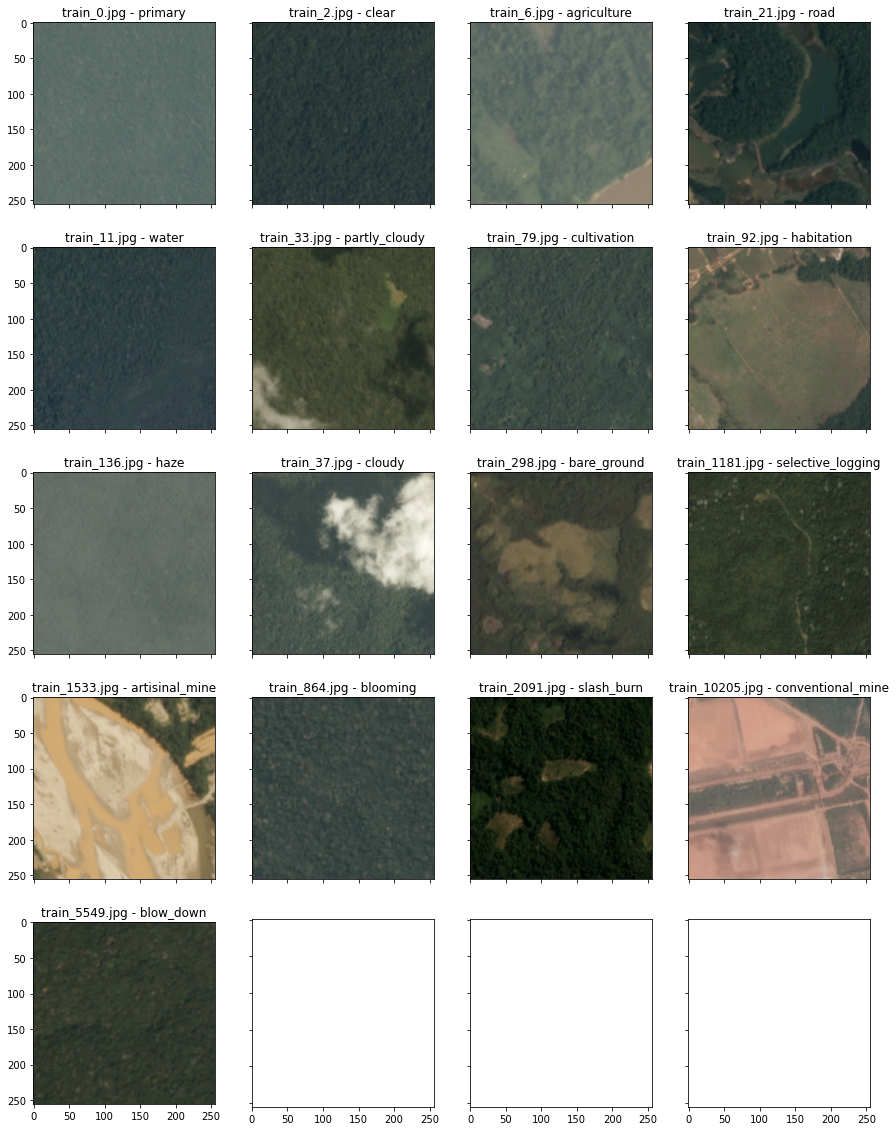

In [21]:
images = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(categor)]

plt.rc('axes', grid=False)
abc, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images, categor)):
    img = mpimg.imread('/content/planet/planet/train-jpg/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

## Getting training and testing images

In [22]:
train_img_dir = pathlib.Path('/content/planet/planet/train-jpg')
train_img_path = sorted(list(train_img_dir.glob('*.jpg')))


test_img_dir = pathlib.Path('/content/planet/planet/test-jpg')
test_img_path = sorted(list(test_img_dir.glob('*.jpg')))


test_add_img_dir = pathlib.Path('/content/test-jpg-additional/test-jpg-additional')
test_add_img_path = sorted(list(test_add_img_dir.glob('*/*.jpg')))

assert len(train_img_path) == len(df)
print(len(test_img_path)+len(test_add_img_path))

40669


## Image Preprocessing

In [23]:
input_size = 64

In [24]:
x_train = []
y_train = []

for f, tags in tqdm(df.values, miniters=1000):
    img = cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [00:49<00:00, 820.00it/s]


(40479, 64, 64, 3)
(40479, 17)


In [25]:
x_test = []

test_jpg_dir = '/content/planet/planet/test-jpg'
test_image_names = os.listdir(test_jpg_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]


test_jpg_add_dir = '/content/test-jpg-additional/test-jpg-additional'
test_add_image_names = os.listdir(test_jpg_add_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(test_jpg_add_dir + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

100%|██████████| 20522/20522 [00:24<00:00, 826.80it/s]


(61191, 64, 64, 3)


In [26]:
X_train = x_train[ :35000]
Y_train = y_train[ :35000]

X_valid = x_train[35000: ]
Y_valid = y_train[35000: ]

## Building the Model Architecture

+ Custom CNN over a pretrained VGG16 Model

In [27]:
input_size = 64
input_channels = 3
batch_size = 64

### Custom CNN with Input Layer, 4 Hidden Layers, 1 Fully-Connected Layer and 1 Output Layer with 17 neurons

In [28]:
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully Connected (FC) Layer
model.add(Dense(512, activation='relu'))
model .add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(17, activation='sigmoid'))

In [29]:
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()

x = base_model.output
x = Flatten()(x)

x = Dense (512 , activation ='relu')(x)
predictions = Dense (17 , activation ='sigmoid')(x)
model = Model(inputs= base_model.input,outputs = predictions)

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

## Data Augmentation

In [30]:

datagen = ImageDataGenerator ( horizontal_flip =True ,
vertical_flip =True ,
zoom_range =0.2,
rotation_range =90 ,
fill_mode ='reflect')

In [31]:

epochs=20 

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [32]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [33]:
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=[fbeta])


callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]


## Fitting the model

In [34]:

model.fit_generator(datagen.flow(X_train,
Y_train,
batch_size =64),
steps_per_epoch =len(X_train)/64 ,
validation_data = datagen.flow ( X_valid,
Y_valid,
batch_size =64),
validation_steps =len(X_valid)/64 ,
epochs =epochs ,
callbacks = callbacks ,
verbose =1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
546/546 [==============================] - 73s 109ms/step - loss: 0.1528 - fbeta: 0.7936 - val_loss: 0.1226 - val_fbeta: 0.8201
Epoch 2/20
546/546 [==============================] - 57s 105ms/step - loss: 0.1194 - fbeta: 0.8354 - val_loss: 0.1171 - val_fbeta: 0.8617
Epoch 3/20
546/546 [==============================] - 58s 105ms/step - loss: 0.1123 - fbeta: 0.8460 - val_loss: 0.1087 - val_fbeta: 0.8575
Epoch 4/20
546/546 [==============================] - 57s 104ms/step - loss: 0.1078 - fbeta: 0.8533 - val_loss: 0.1107 - val_fbeta: 0.8539
Epoch 5/20
546/546 [==============================] - 57s 105ms/step - loss: 0.1059 - fbeta: 0.8560 - val_loss: 0.1068 - val_fbeta: 0.8616
Epoch 6/20
546/546 [==============================] - 58s 106ms/step - loss: 0.1045 - fbeta: 0.8576 - val_loss: 0.1067 - val_fbeta: 0.8563
Epoch 7/20
546/546 [==============================] - 58s 106ms/step - loss: 0.1026 - fbeta: 0.8600 - val_loss: 0.1016 - val_fbeta: 0.8620
Epoch 8/20
546/546 [=======

## Predicting the values for the additional test data of the competition

In [35]:
test_1 =[]
test_1.append (model.predict (x_test , batch_size = 128 , verbose =2) ) 

479/479 - 26s - 26s/epoch - 53ms/step


In [36]:
result = np.array (test_1[0])
for i in range (1,len(test_1) ):
 result += np. array (test_1)
result = pd.DataFrame (result,columns = labels )
result

,selective_logging,primary,road,habitation,agriculture,haze,cultivation,cloudy,bare_ground,artisinal_mine,blow_down,clear,water,conventional_mine,partly_cloudy,blooming,slash_burn
0,0.010271,0.999904,0.008162,0.005010,0.033533,0.001900,0.019972,0.000045,0.000479,0.000093,0.007339,0.992824,0.015987,0.000071,0.006056,0.113638,0.000256
1,0.009661,0.999982,0.007493,0.002704,0.012463,0.000277,0.008423,0.000008,0.000162,0.000032,0.005337,0.999181,0.013250,0.000020,0.000752,0.122453,0.000066
2,0.000224,0.999735,0.022977,0.000979,0.033976,0.000100,0.004018,0.000269,0.000062,0.000003,0.000670,0.000184,0.023347,0.000011,0.999226,0.000248,0.000149
3,0.006711,0.999829,0.078005,0.013507,0.603062,0.011399,0.535112,0.000065,0.009220,0.001622,0.006258,0.967764,0.129573,0.000602,0.014633,0.016464,0.010937
4,0.000297,0.955660,0.023735,0.001437,0.013397,0.002697,0.003534,0.050100,0.000176,0.000039,0.000504,0.001193,0.022858,0.000059,0.936036,0.000175,0.000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,0.000091,0.647297,0.014025,0.001887,0.009767,0.002068,0.002582,0.384263,0.000173,0.000036,0.000102,0.000618,0.014274,0.000049,0.714165,0.000038,0.000131
61187,0.003572,0.999647,0.093452,0.019439,0.107185,0.000696,0.034124,0.000022,0.004312,0.000101,0.000556,0.998466,0.950799,0.000051,0.001012,0.007240,0.000449
61188,0.007239,0.999844,0.283923,0.007406,0.034887,0.001111,0.014637,0.000031,0.001241,0.000073,0.001144,0.995525,0.591561,0.000084,0.003327,0.007959,0.000385
61189,0.000021,0.229371,0.006874,0.000951,0.005012,0.160664,0.001550,0.787615,0.000146,0.000029,0.000038,0.005213,0.017363,0.000044,0.003910,0.000033,0.000028


In [37]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:47<00:00, 566.99it/s]


## Saving the prediction csv file to upload on Kaggle

In [38]:
# The submission csv
test_df['tags'] = preds
test_df.to_csv('amazon_submission01.csv', index=False)